In [20]:
# Customer Segmentation — End-to-end (compact runnable script)
# Requirements: pandas, numpy, scikit-learn, matplotlib, seaborn, umap-learn (optional)
# pip install pandas numpy scikit-learn matplotlib seaborn umap-learn

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score



In [21]:

sns.set(style="whitegrid")
RANDOM_STATE = 42

# ------------------------------
# 0) Paths & load data
# ------------------------------
DATA_PATH = "/Users/rohanpatil/Desktop/ai_ml_projects/project_2/data/data.csv"   # <- change to your file path
# Expected columns: Order ID,Order Date,Customer Name,Region,City,Category,Sub-Category,Product Name,
# Quantity,Unit Price,Discount,Sales,Profit,Payment Mode

df = pd.read_csv(DATA_PATH, parse_dates=['Order Date'])   # adjust column name if different
print("Loaded:", df.shape)
df.head()



Loaded: (5000, 14)


,Order ID,Order Date,Customer Name,Region,City,Category,Sub-Category,Product Name,Quantity,Unit Price,Discount,Sales,Profit,Payment Mode
0,10001,2024-10-19,Kashvi Varty,South,Bangalore,Books,Non-Fiction,Non-Fiction Ipsum,2,36294,5,68958.6,10525.09,Debit Card
1,10002,2025-08-30,Advik Desai,North,Delhi,Groceries,Rice,Rice Nemo,1,42165,20,33732.0,6299.66,Debit Card
2,10003,2023-11-04,Rhea Kalla,East,Patna,Kitchen,Juicer,Juicer Odio,4,64876,20,207603.2,19850.27,Credit Card
3,10004,2025-05-23,Anika Sen,East,Kolkata,Groceries,Oil,Oil Doloribus,5,37320,15,158610.0,36311.02,UPI
4,10005,2025-01-19,Akarsh Kaul,West,Pune,Clothing,Kids Wear,Kids Wear Quo,1,50037,10,45033.3,9050.04,Debit Card


In [22]:
# ------------------------------
# 1) Basic cleaning
# ------------------------------
# drop rows with missing customer or sales
df = df.dropna(subset=['Customer Name', 'Sales', 'Order Date'])
# ensure numeric
df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce').fillna(0)
df['Sales'] = pd.to_numeric(df['Sales'], errors='coerce').fillna(0.0)
df['Profit'] = pd.to_numeric(df['Profit'], errors='coerce').fillna(0.0)
df['Discount'] = pd.to_numeric(df['Discount'], errors='coerce').fillna(0.0)
# clean customer name whitespace
df['Customer Name'] = df['Customer Name'].astype(str).str.strip()

# Optionally treat refunds/cancellations: remove negative sales if you want
df = df[df['Sales'] >= 0]

print("After cleaning:", df.shape)

After cleaning: (5000, 14)


In [24]:
# ------------------------------
# 2) Aggregate per order (optional)
# ------------------------------
# compute order-level metrics if multiple lines per order
order_agg = df.groupby(['Order ID','Order Date','Customer Name']).agg(
    OrderRevenue=('Sales','sum'),
    OrderItems=('Quantity','sum'),
    OrderProfit=('Profit','sum'),
    OrderDiscount=('Discount','mean'),
    NumDistinctProducts=('Product Name','nunique'),
).reset_index()

In [25]:
order_agg

,Order ID,Order Date,Customer Name,OrderRevenue,OrderItems,OrderProfit,OrderDiscount,NumDistinctProducts
0,10001,2024-10-19,Kashvi Varty,68958.6,2,10525.09,5.0,1
1,10002,2025-08-30,Advik Desai,33732.0,1,6299.66,20.0,1
2,10003,2023-11-04,Rhea Kalla,207603.2,4,19850.27,20.0,1
3,10004,2025-05-23,Anika Sen,158610.0,5,36311.02,15.0,1
4,10005,2025-01-19,Akarsh Kaul,45033.3,1,9050.04,10.0,1
...,...,...,...,...,...,...,...,...
4995,14996,2024-06-25,Nishith Kulkarni,182013.0,3,11853.15,0.0,1
4996,14997,2024-12-22,Aaina Chander,350240.0,5,31237.23,0.0,1
4997,14998,2025-04-15,Dhanush Gara,35837.7,1,7827.50,15.0,1
4998,14999,2024-07-08,Divyansh Malhotra,48844.8,4,6603.86,10.0,1


## Ravi -> 1 10/01 | 100
## Ravi -> 2 15/01 | 500

## Window : 06/Oct/2025 to 

Recency -> 5
Frequncy -> 2
Monetary -> 600




snapshot_date # 2025-10-04 - 2025-01-15 -> ## Recency

RFM : Recency , Frequncy , Monetary 

In [33]:
snapshot_date = order_agg['Order Date'].max() + pd.Timedelta(days=1)

In [34]:
snapshot_date

Timestamp('2025-10-04 00:00:00')

In [29]:
order_agg['Order Date'].max()

Timestamp('2025-10-03 00:00:00')

In [30]:
import datetime 

In [32]:
snapshot_date = datetime.datetime.now()
snapshot_date

datetime.datetime(2025, 10, 6, 21, 44, 31, 399144)

In [35]:
# ------------------------------
# 3) Build RFM + derived features per customer
# ------------------------------
snapshot_date = order_agg['Order Date'].max() + pd.Timedelta(days=1)

rfm = order_agg.groupby('Customer Name').agg(
    Recency = ('Order Date', lambda x: (snapshot_date - x.max()).days),
    Frequency = ('Order ID', 'nunique'),
    Monetary = ('OrderRevenue', 'sum'),
    AvgBasket = ('OrderRevenue', 'mean'),
    TotalItems = ('OrderItems', 'sum'),
    AvgDiscount = ('OrderDiscount', 'mean'),
    DistinctProducts = ('NumDistinctProducts', 'sum'),
    AvgProfit = ('OrderProfit', 'mean')
).reset_index()

# handle NaNs
numeric_cols = ['Recency','Frequency','Monetary','AvgBasket','TotalItems','AvgDiscount','DistinctProducts','AvgProfit']
for c in numeric_cols:
    rfm[c] = rfm[c].fillna(0)

print("RFM shape:", rfm.shape)
rfm.head()


RFM shape: (4844, 9)


,Customer Name,Recency,Frequency,Monetary,AvgBasket,TotalItems,AvgDiscount,DistinctProducts,AvgProfit
0,Aaina Balasubramanian,643,1,158876.8,158876.8,4,20.0,1,23210.84
1,Aaina Bhargava,15,1,26411.9,26411.9,2,5.0,1,3768.47
2,Aaina Bir,133,1,231044.0,231044.0,5,20.0,1,57568.32
3,Aaina Chander,286,1,350240.0,350240.0,5,0.0,1,31237.23
4,Aaina Chandran,572,1,43747.5,43747.5,3,5.0,1,8556.76


## first , Second , third , fourth 


9D to 2D Dimensionality reducion

In [49]:
# ------------------------------
# 4) Feature transforms (stabilize distribution)
# ------------------------------
feat_cols = ['Recency','Frequency','Monetary','AvgBasket','TotalItems','AvgDiscount','DistinctProducts','AvgProfit']

# log1p for skewed positive features
for c in ['Monetary','AvgBasket','TotalItems','DistinctProducts','Frequency','AvgProfit']:
    rfm[c+'_log'] = np.log1p(rfm[c])

# use a working feature matrix
X = rfm[['Recency','Frequency_log','Monetary_log','AvgBasket_log','TotalItems_log','AvgDiscount','DistinctProducts_log','AvgProfit_log']].fillna(0)
X.columns = ['Recency','Frequency','Monetary','AvgBasket','TotalItems','AvgDiscount','DistinctProducts','AvgProfit']

# scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [39]:
def std_recency(recency):
    mean = X['Recency'].mean()
    std = X['Recency'].std()
    z_i = (recency - mean) / std
    return z_i

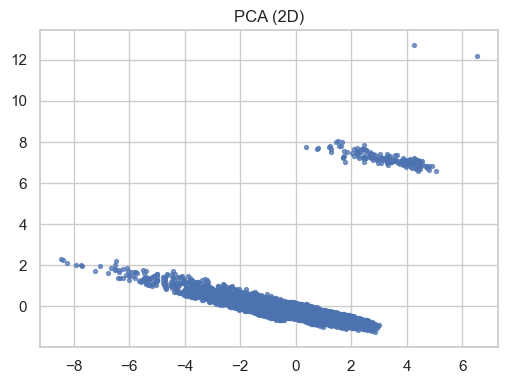

In [52]:
# ------------------------------
# 5) Dimensionality reduction (PCA + optional UMAP)
# ------------------------------
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

# try UMAP if installed
try:
    import umap
    reducer = umap.UMAP(n_components=2, random_state=RANDOM_STATE)
    X_umap = reducer.fit_transform(X_scaled)
    have_umap = True
except Exception:
    X_umap = None
    have_umap = False

# quick plot
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(X_pca[:,0], X_pca[:,1], s=8, alpha=0.7)
plt.title("PCA (2D)")
if have_umap:
    plt.subplot(1,2,2)
    plt.scatter(X_umap[:,0], X_umap[:,1], s=8, alpha=0.7)
    plt.title("UMAP (2D)")
plt.tight_layout()
plt.show()

In [53]:
# ------------------------------
# 6) Choose K for KMeans (silhouette loop)
# ------------------------------
sil_scores = {}
for k in range(2,9):
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labs = km.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labs)
    sil_scores[k] = sil
print("Silhouette scores (KMeans):", sil_scores)

# pick best k by silhouette
best_k = max(sil_scores, key=sil_scores.get)
print("Best k (silhouette):", best_k)


Silhouette scores (KMeans): {2: 0.28482551672724016, 3: 0.3337726161362633, 4: 0.25952468121635835, 5: 0.23062483560469957, 6: 0.22784752688949972, 7: 0.22491186688892884, 8: 0.23067644466877862}
Best k (silhouette): 3


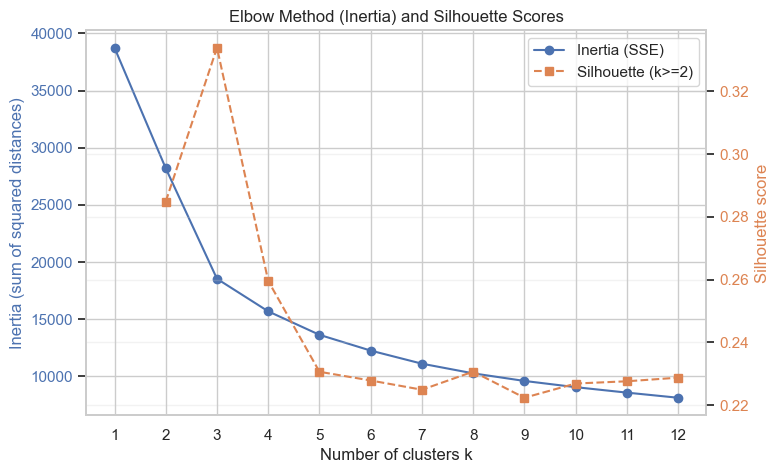

In [54]:
# Elbow method + silhouette overlay
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# X_scaled: your scaled feature matrix (numpy array or DataFrame)
# if you used DataFrame, you can do X_scaled = scaler.transform(X_df)
# set range
K_max = 12
ks = list(range(1, K_max+1))
inertia = []
sil_scores = []

for k in ks:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    km.fit(X_scaled)
    inertia.append(km.inertia_)
    if k >= 2:
        labels = km.labels_
        sil = silhouette_score(X_scaled, labels)
        sil_scores.append(sil)
    else:
        sil_scores.append(np.nan)  # placeholder for k=1

# Plot
fig, ax1 = plt.subplots(figsize=(8,5))
ax1.plot(ks, inertia, 'o-', color='C0', label='Inertia (SSE)')
ax1.set_xlabel('Number of clusters k')
ax1.set_ylabel('Inertia (sum of squared distances)', color='C0')
ax1.tick_params(axis='y', labelcolor='C0')
ax1.set_xticks(ks)

# annotate potential elbows (optional simple heuristic: big drops)
drops = np.diff(inertia)
for i in range(1, len(drops)):
    # mark points where drop slows down (optional heuristic)
    if drops[i] > 0 and abs(drops[i-1]) - abs(drops[i]) > 0.1 * abs(drops[i-1]):
        ax1.axvline(x=ks[i+1], color='grey', linestyle='--', alpha=0.4)

# add silhouette on secondary axis
ax2 = ax1.twinx()
ax2.plot(ks, sil_scores, 's--', color='C1', label='Silhouette (k>=2)')
ax2.set_ylabel('Silhouette score', color='C1')
ax2.tick_params(axis='y', labelcolor='C1')

# legends
lns = ax1.get_lines() + ax2.get_lines()
labels = [l.get_label() for l in lns]
ax1.legend(lns, labels, loc='best')
plt.title('Elbow Method (Inertia) and Silhouette Scores')
plt.grid(alpha=0.25)
plt.show()


In [55]:
# ------------------------------
# 7) Clustering: KMeans, GMM, DBSCAN
# ------------------------------
kmeans = KMeans(n_clusters=best_k, random_state=RANDOM_STATE, n_init=20).fit(X_scaled)
klabels = kmeans.labels_

gmm = GaussianMixture(n_components=best_k, random_state=RANDOM_STATE).fit(X_scaled)
glabels = gmm.predict(X_scaled)

db = DBSCAN(eps=0.6, min_samples=5)
dlabels = db.fit_predict(X_scaled)

In [56]:
# ------------------------------
# 8) Validation metrics
# ------------------------------
def cluster_scores(Xs, labs):
    mask = labs != -1
    if np.unique(labs[mask]).size < 2:
        return {'silhouette': np.nan, 'davies_bouldin': np.nan}
    try:
        s = silhouette_score(Xs[mask], labs[mask])
    except:
        s = np.nan
    try:
        dbi = davies_bouldin_score(Xs[mask], labs[mask])
    except:
        dbi = np.nan
    return {'silhouette': s, 'davies_bouldin': dbi}

scores = {
    'KMeans': cluster_scores(X_scaled, klabels),
    'GMM': cluster_scores(X_scaled, glabels),
    'DBSCAN': cluster_scores(X_scaled, dlabels)
}
pd.DataFrame(scores).T

,silhouette,davies_bouldin
KMeans,0.333773,0.983785
GMM,0.320527,1.008848
DBSCAN,-0.005095,2.210502


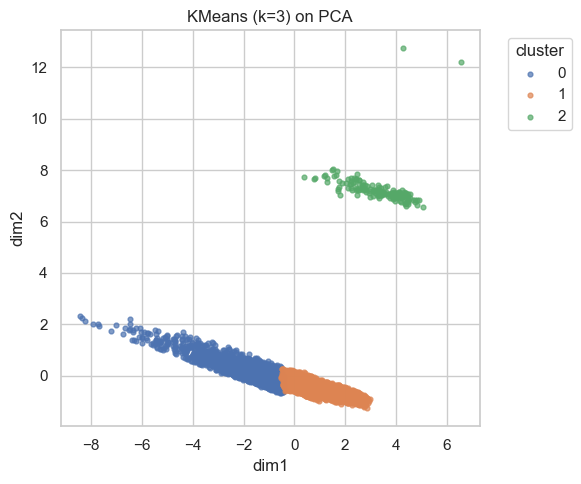

In [57]:
# ------------------------------
# 9) Visualize clusters on PCA/UMAP
# ------------------------------
def plot_emb(emb, labs, title):
    plt.figure(figsize=(6,5))
    unique = np.unique(labs)
    for lab in unique:
        mask = labs == lab
        plt.scatter(emb[mask,0], emb[mask,1], s=12, alpha=0.7, label=str(lab))
    plt.legend(title='cluster', bbox_to_anchor=(1.05,1), loc='upper left')
    plt.title(title)
    plt.xlabel('dim1'); plt.ylabel('dim2')
    plt.tight_layout()
    plt.show()

plot_emb(X_pca, klabels, f"KMeans (k={best_k}) on PCA")
if have_umap:
    plot_emb(X_umap, klabels, f"KMeans (k={best_k}) on UMAP")


In [59]:
# ------------------------------
# 10) Cluster profiling (human-readable)
# ------------------------------
rfm_profile = rfm.copy()
rfm_profile['cluster_kmeans'] = klabels

profile = rfm_profile.groupby('cluster_kmeans').agg(
    customers = ('Customer Name','count'),
    Recency_mean = ('Recency','mean'),
    Frequency_mean = ('Frequency','mean'),
    Monetary_sum = ('Monetary','sum'),
    AvgBasket_mean = ('AvgBasket','mean'),
    AvgDiscount_mean = ('AvgDiscount','mean'),
    DistinctProducts_mean = ('DistinctProducts','mean'),
    AvgProfit_mean = ('AvgProfit','mean'),
).reset_index().sort_values('Monetary_sum', ascending=False)

# show and print readable metrics (Monetary not logged)
display(profile)
print(profile.to_string(index=False))


,cluster_kmeans,customers,Recency_mean,Frequency_mean,Monetary_sum,AvgBasket_mean,AvgDiscount_mean,DistinctProducts_mean,AvgProfit_mean
1,1,2902,366.423501,1.000000,4.433615e+08,152777.901120,9.772571,1.000000,22900.894266
0,0,1788,370.093960,1.000000,5.651194e+07,31606.232215,10.480984,1.000000,4464.287125
2,2,154,257.837662,2.012987,3.379261e+07,108821.230844,10.183983,2.012987,16968.935768


 cluster_kmeans  customers  Recency_mean  Frequency_mean  Monetary_sum  AvgBasket_mean  AvgDiscount_mean  DistinctProducts_mean  AvgProfit_mean
              1       2902    366.423501        1.000000  443361469.05   152777.901120          9.772571               1.000000    22900.894266
              0       1788    370.093960        1.000000   56511943.20    31606.232215         10.480984               1.000000     4464.287125
              2        154    257.837662        2.012987   33792612.10   108821.230844         10.183983               2.012987    16968.935768


In [60]:
# ------------------------------
# 11) Map clusters to personas (example)
# ------------------------------
# Simple heuristics to label clusters (tune for your data)
def persona_map(row):
    if row['Frequency_mean'] > rfm['Frequency'].quantile(0.75) and row['AvgBasket_mean'] > rfm['AvgBasket'].quantile(0.75):
        return "Loyal High Spenders"
    if row['Recency_mean'] > rfm['Recency'].quantile(0.75) and row['Monetary_sum'] > rfm['Monetary'].quantile(0.75):
        return "Dormant High Value"
    if row['AvgDiscount_mean'] > rfm['AvgDiscount'].quantile(0.75):
        return "Deal Seekers"
    return "Regular"

profile['persona'] = profile.apply(persona_map, axis=1)
display(profile[['cluster_kmeans','customers','persona']])

,cluster_kmeans,customers,persona
1,1,2902,Regular
0,0,1788,Regular
2,2,154,Regular


In [61]:
# ------------------------------
# 12) Export cluster assignments
# ------------------------------
out = rfm_profile[['Customer Name','Recency','Frequency','Monetary','cluster_kmeans']]
out.to_csv('customer_segments.csv', index=False)
print("Saved customer_segments.csv:", out.shape)

Saved customer_segments.csv: (4844, 5)


In [62]:
# ------------------------------
# 13) Quick business actions (print)
# ------------------------------
for _, r in profile.iterrows():
    print(f"\nCluster {int(r['cluster_kmeans'])} — customers: {int(r['customers'])}")
    print("  Recency(mean):", round(r['Recency_mean'],1), 
          "Frequency(mean):", round(r['Frequency_mean'],2),
          "Monetary(sum):", round(r['Monetary_sum'],2))
    # action templates
    if r['persona']=="Loyal High Spenders":
        print(" Action: VIP program, premium bundles, early access sales.")
    elif r['persona']=="Dormant High Value":
        print(" Action: Win-back campaigns with exclusive discounts.")
    elif r['persona']=="Deal Seekers":
        print(" Action: Coupons, bundle deals, loyalty points reminders.")
    else:
        print(" Action: General cross-sell/up-sell, email recommendations.")

print("\nDone.")


Cluster 1 — customers: 2902
  Recency(mean): 366.4 Frequency(mean): 1.0 Monetary(sum): 443361469.05
 Action: General cross-sell/up-sell, email recommendations.

Cluster 0 — customers: 1788
  Recency(mean): 370.1 Frequency(mean): 1.0 Monetary(sum): 56511943.2
 Action: General cross-sell/up-sell, email recommendations.

Cluster 2 — customers: 154
  Recency(mean): 257.8 Frequency(mean): 2.01 Monetary(sum): 33792612.1
 Action: General cross-sell/up-sell, email recommendations.

Done.


## PCA : Principle Component Analysis 

### 100 columns (92) : 8 Columns